### Clustering Analysis - Step 1: Load Engineered Dataset
**Description:**

Import necessary libraries and load the engineered features dataset (36 countries × 9 features) that was prepared in the feature engineering phase.

In [34]:
# Clustering Analysis Notebook
# ============================
# Project: Healthcare Expenditure Clustering Analysis
# Purpose: Identify country clusters for pharmaceutical market entry strategy

# Step 1: Import Libraries and Load Engineered Dataset
# =====================================================

print("="*70)
print("CLUSTERING ANALYSIS - PHARMACEUTICAL SPENDING SEGMENTATION")
print("="*70)

# 1.1 Import necessary libraries
print("\n1.1 Importing Libraries...")

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
print("✓ Libraries imported successfully")


CLUSTERING ANALYSIS - PHARMACEUTICAL SPENDING SEGMENTATION

1.1 Importing Libraries...
✓ Libraries imported successfully


In [3]:
# 1.2 Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
pd.set_option('display.width', None)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Display settings configured")

# Load the engineered features dataset
print("\n1.3 Loading Engineered Features Dataset...")

file_path = '../Data/processing/engineered_features.csv'
df = pd.read_csv(file_path)

print(f"✓ Data loaded successfully from: {file_path}")

✓ Display settings configured

1.3 Loading Engineered Features Dataset...
✓ Data loaded successfully from: ../Data/processing/engineered_features.csv


In [4]:
df.head()

,COUNTRY,PC_HEALTHXP_growth,PC_GDP_growth,USD_CAP_growth,PC_HEALTHXP_avg,PC_GDP_avg,USD_CAP_avg,PC_HEALTHXP_volatility,PC_GDP_volatility,USD_CAP_volatility
0,AUS,-2.71,-0.25,1.73,13.10,1.26,611.46,1.36,0.04,34.19
1,AUT,-0.15,1.28,3.24,12.06,1.26,615.25,0.16,0.05,55.77
2,BEL,-2.16,-1.32,1.23,12.07,1.29,582.93,0.78,0.06,27.41
3,CAN,-2.51,-0.01,1.15,16.48,1.79,799.78,1.01,0.05,43.79
4,CHE,0.55,2.30,3.90,10.44,1.12,649.75,0.23,0.07,71.15


### Feature Scaling
**Description:**

Standardize the features so they all have mean=0 and standard deviation=1. This ensures that features with larger values (like USD_CAP_avg) don't dominate the clustering over features with smaller values (like PC_GDP_avg).

In [10]:
# Step 2: Feature Scaling
# =======================

# Separate features from country identifiers
countries = df['COUNTRY'].values
feature_columns = [col for col in df.columns if col != 'COUNTRY']
X = df[feature_columns].values

X

array([[-2.70626371e+00, -2.49001461e-01,  1.73488341e+00,
         1.31034000e+01,  1.26410000e+00,  6.11460500e+02,
         1.35788784e+00,  4.02808198e-02,  3.41940265e+01],
       [-1.45484374e-01,  1.27662470e+00,  3.23578364e+00,
         1.20644000e+01,  1.25710000e+00,  6.15252400e+02,
         1.56730625e-01,  4.61433756e-02,  5.57725363e+01],
       [-2.16390245e+00, -1.32060769e+00,  1.22756160e+00,
         1.20686000e+01,  1.29340000e+00,  5.82929400e+02,
         7.82231310e-01,  6.05038107e-02,  2.74085245e+01],
       [-2.51445121e+00, -1.19660177e-02,  1.15038010e+00,
         1.64811000e+01,  1.79310000e+00,  7.99781000e+02,
         1.00808327e+00,  5.28298106e-02,  4.37870586e+01],
       [ 5.53732958e-01,  2.30442182e+00,  3.90297955e+00,
         1.04399000e+01,  1.12190000e+00,  6.49747100e+02,
         2.29655031e-01,  7.33855117e-02,  7.11474150e+01],
       [-6.41878513e+00, -6.78473737e+00, -3.04464357e+00,
         1.20081000e+01,  9.12100000e-01,  1.633874

In [11]:
# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create scaled dataframe
df_scaled = pd.DataFrame(X_scaled, columns=feature_columns)
df_scaled.insert(0, 'COUNTRY', countries)

print(f"✓ Scaled {len(feature_columns)} features for {len(countries)} countries")
print(df_scaled.head())

✓ Scaled 9 features for 36 countries
  COUNTRY  PC_HEALTHXP_growth  PC_GDP_growth  USD_CAP_growth  PC_HEALTHXP_avg  \
0     AUS               -0.64           0.10           -0.31            -0.58   
1     AUT                0.92           0.81            0.44            -0.75   
2     BEL               -0.31          -0.40           -0.56            -0.75   
3     CAN               -0.52           0.21           -0.60            -0.05   
4     CHE                1.35           1.29            0.77            -1.00   

   PC_GDP_avg  USD_CAP_avg  PC_HEALTHXP_volatility  PC_GDP_volatility  \
0       -0.29         0.48                    0.08              -0.82   
1       -0.31         0.51                   -0.97              -0.75   
2       -0.22         0.32                   -0.42              -0.57   
3        1.01         1.54                   -0.22              -0.66   
4       -0.64         0.70                   -0.91              -0.41   

   USD_CAP_volatility  
0            

### Feature Scaling

In [12]:
# Step 3: Determine Optimal Number of Clusters (Elbow Method)
# ============================================================

# Test different numbers of clusters
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

inertias

[232.18231448312923,
 188.86081732382252,
 158.77104071973633,
 136.89550517920406,
 120.78558488186842,
 105.89229513889511,
 90.31018517103686,
 77.51223218128678,
 69.05755949849906]

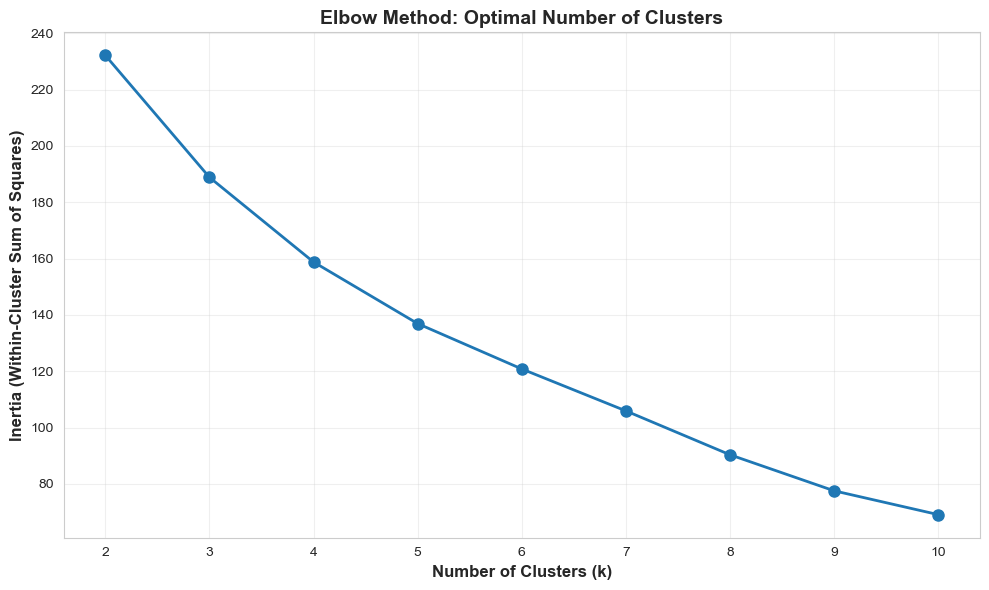

✓ Tested k from 2 to 10 clusters

Look for the 'elbow' where the curve bends - that's your optimal k


In [13]:
# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
plt.title('Elbow Method: Optimal Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

print(f"✓ Tested k from {min(K_range)} to {max(K_range)} clusters")
print("\nLook for the 'elbow' where the curve bends - that's your optimal k")

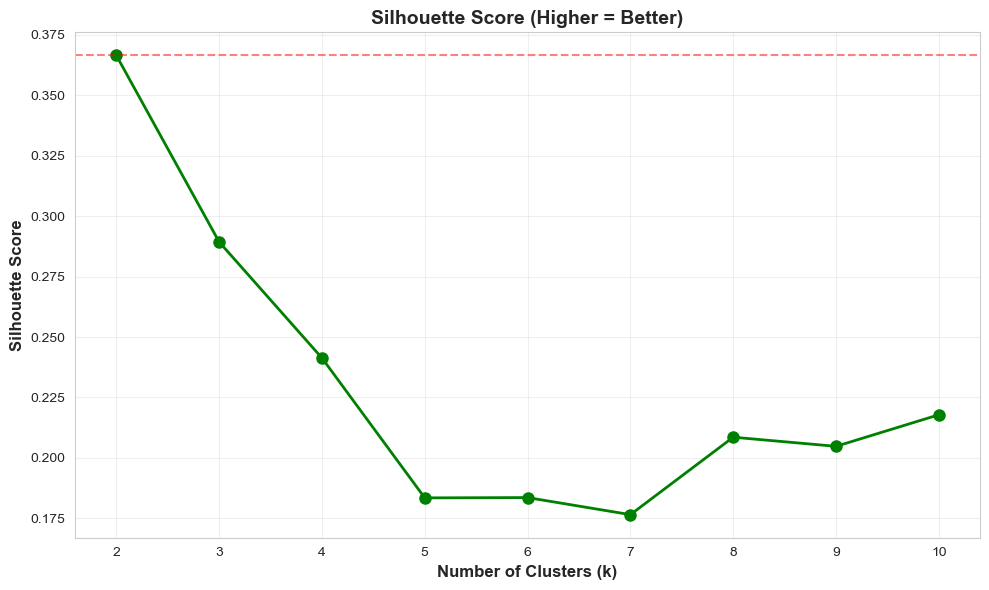


Silhouette Scores:
  k=2: 0.367
  k=3: 0.289
  k=4: 0.241
  k=5: 0.183
  k=6: 0.184
  k=7: 0.177
  k=8: 0.209
  k=9: 0.205
  k=10: 0.218

✓ Best k by Silhouette Score: 2


In [15]:
# Silhouette Score Method
# =================================

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))

# Silhouette Score (higher is better)
plt.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='green')
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=12, fontweight='bold')
plt.title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.axhline(y=max(silhouette_scores), color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print results
print("\nSilhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"  k={k}: {score:.3f}")

best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✓ Best k by Silhouette Score: {best_k}")

### Apply K-Means Clustering (k=2 and k=3)

In [17]:
# Step 4: Apply K-Means Clustering
# =================================

# Apply K-Means with k=2
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_2 = kmeans_2.fit_predict(X_scaled)

# Apply K-Means with k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_3 = kmeans_3.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_scaled['Cluster_k2'] = clusters_2
df_scaled['Cluster_k3'] = clusters_3

df_scaled.head(10)

,COUNTRY,PC_HEALTHXP_growth,PC_GDP_growth,USD_CAP_growth,PC_HEALTHXP_avg,PC_GDP_avg,USD_CAP_avg,PC_HEALTHXP_volatility,PC_GDP_volatility,USD_CAP_volatility,Cluster_k2,Cluster_k3
0,AUS,-0.64,0.10,-0.31,-5.83e-01,-0.29,0.48,0.08,-8.19e-01,-0.60,1,1
1,AUT,0.92,0.81,0.44,-7.46e-01,-0.31,0.51,-0.97,-7.46e-01,0.35,1,1
2,BEL,-0.31,-0.40,-0.56,-7.45e-01,-0.22,0.32,-0.42,-5.68e-01,-0.90,1,1
3,CAN,-0.52,0.21,-0.60,-5.44e-02,1.01,1.54,-0.22,-6.63e-01,-0.18,1,1
4,CHE,1.35,1.29,0.77,-1.00e+00,-0.64,0.70,-0.91,-4.09e-01,1.02,1,1
5,CRI,-2.91,-2.96,-2.67,-7.55e-01,-1.15,-2.02,1.54,1.79e+00,-0.79,0,0
6,CYP,0.19,0.98,0.58,-6.38e-04,-0.55,-0.75,0.20,-3.26e-01,0.46,1,1
7,CZE,-0.66,-0.05,0.43,1.34e-01,-0.07,-0.20,0.27,-6.38e-04,-0.24,1,1
8,DEU,0.70,0.83,0.93,-4.22e-01,0.53,1.49,-0.87,-5.92e-01,2.38,1,2
9,DNK,-0.08,-0.53,-0.46,-1.57e+00,-1.68,-1.09,-0.77,-7.44e-01,-1.22,1,1


In [18]:
# Display results
print("✓ Clustering completed for k=2 and k=3\n")

print("Cluster Distribution (k=2):")
print(df_scaled['Cluster_k2'].value_counts().sort_index())

print("\nCluster Distribution (k=3):")
print(df_scaled['Cluster_k3'].value_counts().sort_index())

print("\nCountries by Cluster (k=2):")
for cluster in sorted(df_scaled['Cluster_k2'].unique()):
    countries_in_cluster = df_scaled[df_scaled['Cluster_k2'] == cluster]['COUNTRY'].tolist()
    print(f"\nCluster {cluster} ({len(countries_in_cluster)} countries):")
    print(f"  {', '.join(countries_in_cluster)}")

print("\n" + "="*70)

print("\nCountries by Cluster (k=3):")
for cluster in sorted(df_scaled['Cluster_k3'].unique()):
    countries_in_cluster = df_scaled[df_scaled['Cluster_k3'] == cluster]['COUNTRY'].tolist()
    print(f"\nCluster {cluster} ({len(countries_in_cluster)} countries):")
    print(f"  {', '.join(countries_in_cluster)}")

✓ Clustering completed for k=2 and k=3

Cluster Distribution (k=2):
Cluster_k2
0     7
1    29
Name: count, dtype: int64

Cluster Distribution (k=3):
Cluster_k3
0     5
1    23
2     8
Name: count, dtype: int64

Countries by Cluster (k=2):

Cluster 0 (7 countries):
  CRI, GRC, HRV, HUN, IRL, ROU, SVK

Cluster 1 (29 countries):
  AUS, AUT, BEL, CAN, CHE, CYP, CZE, DEU, DNK, ESP, EST, FIN, FRA, ISL, ISR, ITA, JPN, KOR, LTU, LUX, LVA, MEX, NLD, NOR, POL, PRT, SVN, SWE, USA


Countries by Cluster (k=3):

Cluster 0 (5 countries):
  CRI, HRV, HUN, IRL, SVK

Cluster 1 (23 countries):
  AUS, AUT, BEL, CAN, CHE, CYP, CZE, DNK, ESP, EST, FIN, FRA, ISL, ISR, ITA, LUX, MEX, NLD, NOR, POL, PRT, SVN, SWE

Cluster 2 (8 countries):
  DEU, GRC, JPN, KOR, LTU, LVA, ROU, USA


In [19]:
# Apply K-Means with k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_4 = kmeans_4.fit_predict(X_scaled)
df_scaled['Cluster_k4'] = clusters_4

print("\nCountries by Cluster (k=4):")
for cluster in sorted(df_scaled['Cluster_k4'].unique()):
    countries_in_cluster = df_scaled[df_scaled['Cluster_k4'] == cluster]['COUNTRY'].tolist()
    print(f"\nCluster {cluster} ({len(countries_in_cluster)} countries):")
    print(f"  {', '.join(countries_in_cluster)}")


Countries by Cluster (k=4):

Cluster 0 (6 countries):
  DEU, JPN, KOR, LTU, LVA, USA

Cluster 1 (20 countries):
  AUS, AUT, BEL, CAN, CHE, CYP, CZE, ESP, EST, FIN, FRA, ISR, ITA, LUX, MEX, NOR, POL, PRT, SVN, SWE

Cluster 2 (5 countries):
  GRC, HRV, HUN, ROU, SVK

Cluster 3 (5 countries):
  CRI, DNK, IRL, ISL, NLD


### Analyze Cluster Characteristics

In [20]:
# Step 5: Cluster Characteristics Analysis
# =========================================

# Add original (unscaled) features back for interpretation
df_results = df.copy()
df_results['Cluster_k2'] = clusters_2
df_results['Cluster_k3'] = clusters_3

df_results.head()

,COUNTRY,PC_HEALTHXP_growth,PC_GDP_growth,USD_CAP_growth,PC_HEALTHXP_avg,PC_GDP_avg,USD_CAP_avg,PC_HEALTHXP_volatility,PC_GDP_volatility,USD_CAP_volatility,Cluster_k2,Cluster_k3
0,AUS,-2.71,-0.25,1.73,13.10,1.26,611.46,1.36,0.04,34.19,1,1
1,AUT,-0.15,1.28,3.24,12.06,1.26,615.25,0.16,0.05,55.77,1,1
2,BEL,-2.16,-1.32,1.23,12.07,1.29,582.93,0.78,0.06,27.41,1,1
3,CAN,-2.51,-0.01,1.15,16.48,1.79,799.78,1.01,0.05,43.79,1,1
4,CHE,0.55,2.30,3.90,10.44,1.12,649.75,0.23,0.07,71.15,1,1


In [21]:
# Analyze k=2 clusters
print("\n" + "="*70)
print("CLUSTER ANALYSIS: k=2")
print("="*70)

for cluster in sorted(df_results['Cluster_k2'].unique()):
    cluster_data = df_results[df_results['Cluster_k2'] == cluster]
    print(f"\n{'='*70}")
    print(f"Cluster {cluster}: {len(cluster_data)} countries")
    print(f"{'='*70}")
    print(f"Countries: {', '.join(cluster_data['COUNTRY'].tolist())}")
    print(f"\nAverage Characteristics:")
    print(cluster_data[feature_columns].mean().to_string())


CLUSTER ANALYSIS: k=2

Cluster 0: 7 countries
Countries: CRI, GRC, HRV, HUN, IRL, ROU, SVK

Average Characteristics:
PC_HEALTHXP_growth         -3.31
PC_GDP_growth              -3.43
USD_CAP_growth              0.31
PC_HEALTHXP_avg            23.41
PC_GDP_avg                  1.65
USD_CAP_avg               468.72
PC_HEALTHXP_volatility      2.71
PC_GDP_volatility           0.25
USD_CAP_volatility         39.38

Cluster 1: 29 countries
Countries: AUS, AUT, BEL, CAN, CHE, CYP, CZE, DEU, DNK, ESP, EST, FIN, FRA, ISL, ISR, ITA, JPN, KOR, LTU, LUX, LVA, MEX, NLD, NOR, POL, PRT, SVN, SWE, USA

Average Characteristics:
PC_HEALTHXP_growth         -1.26
PC_GDP_growth               0.26
USD_CAP_growth              2.85
PC_HEALTHXP_avg            15.24
PC_GDP_avg                  1.32
USD_CAP_avg               538.62
PC_HEALTHXP_volatility      0.91
PC_GDP_volatility           0.07
USD_CAP_volatility         49.93


In [22]:
# Analyze k=3 clusters
print("\n\n" + "="*70)
print("CLUSTER ANALYSIS: k=3")
print("="*70)

for cluster in sorted(df_results['Cluster_k3'].unique()):
    cluster_data = df_results[df_results['Cluster_k3'] == cluster]
    print(f"\n{'='*70}")
    print(f"Cluster {cluster}: {len(cluster_data)} countries")
    print(f"{'='*70}")
    print(f"Countries: {', '.join(cluster_data['COUNTRY'].tolist())}")
    print(f"\nAverage Characteristics:")
    print(cluster_data[feature_columns].mean().to_string())



CLUSTER ANALYSIS: k=3

Cluster 0: 5 countries
Countries: CRI, HRV, HUN, IRL, SVK

Average Characteristics:
PC_HEALTHXP_growth         -3.63
PC_GDP_growth              -4.58
USD_CAP_growth             -0.75
PC_HEALTHXP_avg            20.76
PC_GDP_avg                  1.51
USD_CAP_avg               449.98
PC_HEALTHXP_volatility      2.38
PC_GDP_volatility           0.26
USD_CAP_volatility         31.18

Cluster 1: 23 countries
Countries: AUS, AUT, BEL, CAN, CHE, CYP, CZE, DNK, ESP, EST, FIN, FRA, ISL, ISR, ITA, LUX, MEX, NLD, NOR, POL, PRT, SVN, SWE

Average Characteristics:
PC_HEALTHXP_growth         -1.24
PC_GDP_growth               0.15
USD_CAP_growth              2.45
PC_HEALTHXP_avg            14.08
PC_GDP_avg                  1.21
USD_CAP_avg               494.75
PC_HEALTHXP_volatility      0.82
PC_GDP_volatility           0.07
USD_CAP_volatility         40.15

Cluster 2: 8 countries
Countries: DEU, GRC, JPN, KOR, LTU, LVA, ROU, USA

Average Characteristics:
PC_HEALTHXP_growth   

### Assign Names And Analyzing Cluster Characteristics

In [27]:
# Analyze clusters first, THEN assign names (Using groupby)
# ===========================================================

# Check which countries are in each cluster
print("Cluster Assignments:")
cluster_countries = df_results.groupby('Cluster_k3')['COUNTRY'].apply(list)

# Check cluster characteristics using groupby
print("\n" + "="*70)
print("CLUSTER CHARACTERISTICS (K-Means k=3)")
print("="*70)

# Calculate all metrics at once using groupby
cluster_profiles_df = df_results.groupby('Cluster_k3').agg({
    'COUNTRY': 'count',
    'PC_HEALTHXP_growth': 'mean',
    'PC_GDP_growth': 'mean',
    'USD_CAP_growth': 'mean',
    'PC_HEALTHXP_avg': 'mean',
    'USD_CAP_avg': 'mean',
    'PC_HEALTHXP_volatility': 'mean'
}).rename(columns={'COUNTRY': 'size'})

# Display cluster profiles
for cluster in cluster_profiles_df.index:
    profile = cluster_profiles_df.loc[cluster]
    
    print(f"\nCluster {cluster} ({int(profile['size'])} countries):")
    print(f"  Pharma Growth: {profile['PC_HEALTHXP_growth']:6.2f}%")
    print(f"  USD Growth:    {profile['USD_CAP_growth']:6.2f}%")
    print(f"  Pharma %:      {profile['PC_HEALTHXP_avg']:6.2f}%")
    print(f"  USD/capita:    ${profile['USD_CAP_avg']:,.0f}")
    print(f"  Volatility:    {profile['PC_HEALTHXP_volatility']:6.2f}")

# NOW assign meaningful names based on characteristics
print("\n" + "="*70)
print("ASSIGNING CLUSTER NAMES BASED ON DATA")
print("="*70)

cluster_names_correct = {}

for cluster in cluster_profiles_df.index:
    profile = cluster_profiles_df.loc[cluster]
    
    if profile['PC_HEALTHXP_growth'] < -2 and profile['USD_CAP_growth'] < 1:
        name = 'Crisis/Declining'
    elif profile['USD_CAP_avg'] > 600 and profile['PC_HEALTHXP_avg'] > 20:
        name = 'High-Value Pharma'
    else:
        name = 'Stable Moderate'
    
    cluster_names_correct[cluster] = name
    print(f"Cluster {cluster} → {name}")

# Create ordered list of names
cluster_names = [cluster_names_correct[i] for i in range(3)]
print(f"\nCluster Names: {cluster_names}")


Cluster Assignments:

CLUSTER CHARACTERISTICS (K-Means k=3)

Cluster 0 (5 countries):
  Pharma Growth:  -3.63%
  USD Growth:     -0.75%
  Pharma %:       20.76%
  USD/capita:    $450
  Volatility:      2.38

Cluster 1 (23 countries):
  Pharma Growth:  -1.24%
  USD Growth:      2.45%
  Pharma %:       14.08%
  USD/capita:    $495
  Volatility:      0.82

Cluster 2 (8 countries):
  Pharma Growth:  -1.63%
  USD Growth:      4.00%
  Pharma %:       22.28%
  USD/capita:    $659
  Volatility:      1.85

ASSIGNING CLUSTER NAMES BASED ON DATA
Cluster 0 → Crisis/Declining
Cluster 1 → Stable Moderate
Cluster 2 → High-Value Pharma

Cluster Names: ['Crisis/Declining', 'Stable Moderate', 'High-Value Pharma']


------------
### CLUSTER INTERPRETATION

#### Cluster 0: "Crisis/Declining Markets" (5 countries)

**Key Characteristics:**
- **Pharma Growth:** -3.63% ← DECLINING fast (worst)
- **USD Growth:** -0.75% ← Negative growth
- **Pharma %:** 20.76% ← High pharma dependence
- **USD/capita:** $450 ← Low spending
- **Volatility:** 2.38 ← VERY UNSTABLE (highest)

**What this means:**
- Countries in economic crisis or austerity
- Cutting healthcare spending (negative growth)
- High pharma dependence but can't afford it
- Unpredictable spending (high volatility = risky)

**Countries:** CRI, HRV, HUN, IRL, SVK

**Market Strategy:**  AVOID or EXIT
- Declining budgets
- High risk (volatile)
- Unpredictable policies
- Low profitability potential

---

#### Cluster 1: "Stable Moderate Growth" (23 countries - LARGEST)

**Key Characteristics:**
- **Pharma Growth:** -1.24% ← Slight decline (moderate)
- **USD Growth:** +2.45% ← GROWING steadily
- **Pharma %:** 14.08% ← Moderate pharma focus (lowest %)
- **USD/capita:** $495 ← Mid-range spending
- **Volatility:** 0.82 ← VERY STABLE (lowest)

**What this means:**
- Mature, stable economies
- Overall healthcare growing (+2.45% per capita)
- Pharma % declining slightly (generic competition, cost control)
- Predictable, low-risk markets
- Largest group (23 countries)

**Countries:** AUS, AUT, BEL, CAN, CHE, FIN, FRA, NOR, SWE, MEX, etc.

**Market Strategy:** STEADY PRESENCE
- Reliable revenue
- Long-term partnerships
- Focus on value and efficiency
- Generic competition strong
- Volume-based business

---

#### Cluster 2: "High-Value Pharma-Intensive" 🎯 (8 countries)

**Key Characteristics:**
- **Pharma Growth:** -1.63% ← Slight decline (similar to Cluster 1)
- **USD Growth:** +4.00% ← HIGHEST growth!
- **Pharma %:** 22.28% ← HIGHEST pharma focus
- **USD/capita:** $659 ← HIGHEST spending (46% more than Cluster 1)
- **Volatility:** 1.85 ← Moderate volatility

**What this means:**
- Wealthy, pharma-focused markets
- Healthcare spending growing fastest (+4%)
- Pharma is huge priority (22% of health budget)
- High absolute spending ($659 vs $495)
- Premium markets willing to pay more

**Countries:** DEU, GRC, JPN, KOR, LTU, LVA, ROU, USA

**Market Strategy:** PRIORITY INVESTMENT
- Highest revenue potential per capita
- Strong pharma culture (22% share)
- Fast-growing total spending (+4%)
- Premium pricing possible
- Innovation-focused
- Strategic importance

---

#### Side-by-Side Comparison

| Metric | Cluster 0<br>(Crisis) | Cluster 1<br>(Stable) | Cluster 2<br>(High-Value) |
|--------|----------------------|----------------------|--------------------------|
| **Growth** | -0.75% ❌ | +2.45% ✅ | +4.00% 🎯 |
| **Spending** | $450 | $495 | $659 💰 |
| **Pharma %** | 20.76% | 14.08% | 22.28% 🎯 |
| **Stability** | 2.38 ⚠️ | 0.82 ✅ | 1.85 ⚠️ |
| **Size** | 5 countries | 23 countries | 8 countries |
| **Strategy** | Avoid | Steady | Invest |
----------------


### Cluster Visualization

In [ ]:
# Interactive Cluster Visualization (Fixed)
# ==================================================

# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Get countries from df_results (not from undefined 'countries' variable)
countries_list = df_results['COUNTRY'].values

# Create dataframe for plotting
plot_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Country_Code': countries_list,
    'Cluster': df_results['Cluster_k3'].values,
    'Cluster_Name': [cluster_names[c] for c in df_results['Cluster_k3'].values]
})

# Add full country names
country_names = {
    'AUS': 'Australia', 'AUT': 'Austria', 'BEL': 'Belgium', 'CAN': 'Canada',
    'CHE': 'Switzerland', 'CRI': 'Costa Rica', 'CYP': 'Cyprus', 'CZE': 'Czech Republic',
    'DEU': 'Germany', 'DNK': 'Denmark', 'ESP': 'Spain', 'EST': 'Estonia',
    'FIN': 'Finland', 'FRA': 'France', 'GBR': 'United Kingdom', 'GRC': 'Greece',
    'HRV': 'Croatia', 'HUN': 'Hungary', 'IRL': 'Ireland', 'ISL': 'Iceland',
    'ISR': 'Israel', 'ITA': 'Italy', 'JPN': 'Japan', 'KOR': 'South Korea',
    'LTU': 'Lithuania', 'LUX': 'Luxembourg', 'LVA': 'Latvia', 'MEX': 'Mexico',
    'NLD': 'Netherlands', 'NOR': 'Norway', 'NZL': 'New Zealand', 'POL': 'Poland',
    'PRT': 'Portugal', 'ROU': 'Romania', 'SVK': 'Slovakia', 'SVN': 'Slovenia',
    'SWE': 'Sweden', 'TUR': 'Turkey', 'USA': 'United States'
}

plot_df['Country_Name'] = plot_df['Country_Code'].map(country_names)

# Add metrics for hover
plot_df['Spending_USD'] = plot_df['Country_Code'].map(
    df_results.set_index('COUNTRY')['USD_CAP_avg']
).round(0)
plot_df['Pharma_Pct'] = plot_df['Country_Code'].map(
    df_results.set_index('COUNTRY')['PC_HEALTHXP_avg']
).round(1)
plot_df['Growth_Pct'] = plot_df['Country_Code'].map(
    df_results.set_index('COUNTRY')['USD_CAP_growth']
).round(2)

# Custom colors
colors = {
    0: '#F24495',  # Pink - Crisis/Declining
    1: '#432E8C',  # Purple - Stable Moderate
    2: '#66C4D9'   # Blue - High-Value Pharma
}

# Create interactive plot
fig = go.Figure()

for cluster in sorted(plot_df['Cluster'].unique()):
    cluster_data = plot_df[plot_df['Cluster'] == cluster]
    
    fig.add_trace(go.Scatter(
        x=cluster_data['PC1'],
        y=cluster_data['PC2'],
        mode='markers',
        name=f'{cluster_names[cluster]}',
        marker=dict(
            size=15,
            color=colors[cluster],
            line=dict(width=2, color='white'),
            opacity=0.8
        ),
        text=cluster_data['Country_Name'],
        customdata=cluster_data[['Country_Code', 'Spending_USD', 'Pharma_Pct', 'Growth_Pct']],
        hovertemplate='<b>%{text}</b><br>' +
                      'Code: %{customdata[0]}<br>' +
                      'Spending: $%{customdata[1]:,.0f}/capita<br>' +
                      'Pharma Share: %{customdata[2]:.1f}%<br>' +
                      'Growth: %{customdata[3]:.2f}%/year<br>' +
                      '<extra></extra>'
    ))

# Update layout
fig.update_layout(
    title={
        'text': 'Country Clusters: Pharmaceutical Spending Segmentation (k=3)',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18, 'family': 'Arial, sans-serif', 'color': '#333'}
    },
    xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)',
    yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)',
    width=900,
    height=600,
    hovermode='closest',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=12, family='Arial, sans-serif'),
    legend=dict(
        title=dict(text='Market Segment', font=dict(size=14, family='Arial, sans-serif')),
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='#ccc',
        borderwidth=1
    ),
    # Add frame/border
    xaxis=dict(
        showline=True,      # Show x-axis line
        linewidth=1,        # Border thickness
        linecolor='black',  # Border color
        mirror=True         # Show line on top too
    ),
    yaxis=dict(
        showline=True,      # Show y-axis line
        linewidth=1,        # Border thickness
        linecolor='black',  # Border color
        mirror=True         # Show line on right too
    )
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#f0f0f0', zeroline=True, zerolinewidth=2, zerolinecolor='#ccc')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#f0f0f0', zeroline=True, zerolinewidth=2, zerolinecolor='#ccc')

fig.show()

print(f"\n✓ Interactive visualization created")


✓ Interactive visualization created


In [35]:
import plotly
print(plotly.__version__)

6.2.0
